In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install Necessary Libraries
!pip install pywavelets
!pip install scikit-learn
!pip install pandas pywavelets numpy
!pip install pywavelets pandas
!pip install tensorflow pandas scikit-learn numpy
!pip install mne numpy scikit-learn
!pip install pymatreader
!pip install torch torchvision pandas
!pip install scikeras
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
#Import Libraries
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
#Load the EEG Data
df = pd.read_csv('/content/drive/MyDrive/eeg_data.csv')
df.head()
print(df)

        sum   max   min label
0     27927   185  -190     A
1   -214866   169  -254     A
2     52053   184  -146     A
3    -16357   162  -181     A
4    -73743   152  -188     A
..      ...   ...   ...   ...
495 -182731   348  -441     E
496  -26957   999 -1341     E
497    8339   568  -735     E
498   90551  1555  -838     E
499   13447  1058  -833     E

[500 rows x 4 columns]


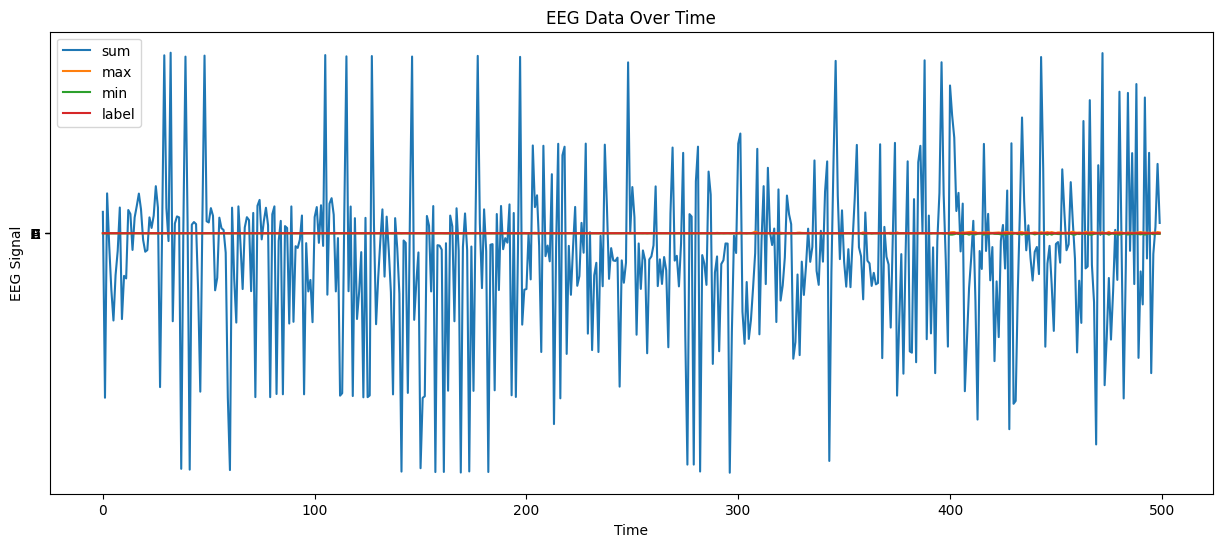

In [ ]:
# Plotting
plt.figure(figsize=(15, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.title('EEG Data Over Time')
plt.legend()
plt.show()

In [ ]:
# Display the first few rows of the DataFrame
print(df.head())

      sum  max  min label
0   27927  185 -190     A
1 -214866  169 -254     A
2   52053  184 -146     A
3  -16357  162 -181     A
4  -73743  152 -188     A


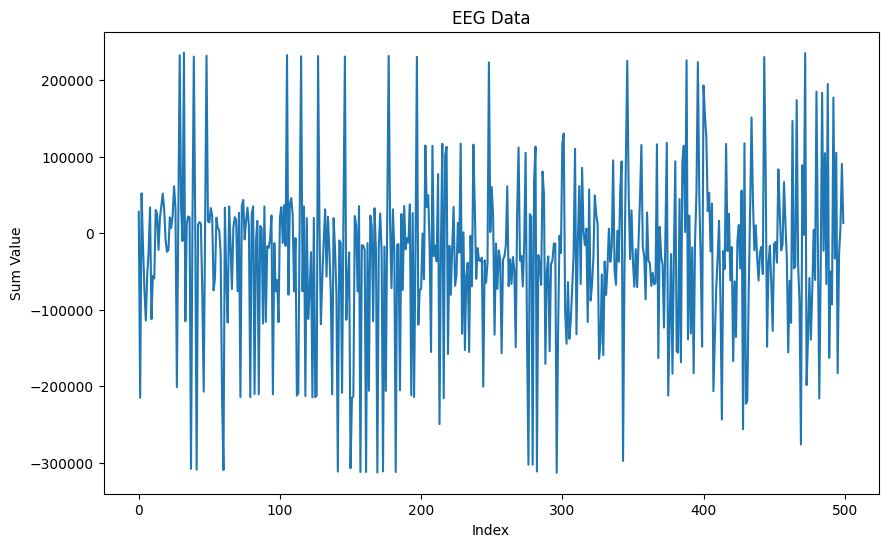

In [ ]:
# Plot the 'sum' column as an example
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sum'])  # Replace 'sum' with 'max' or 'min' if you want to plot those instead
plt.title('EEG Data')
plt.xlabel('Index')
plt.ylabel('Sum Value')  # Replace 'Sum Value' with the appropriate label for the column you're plotting
plt.show()

**Preprocessing**

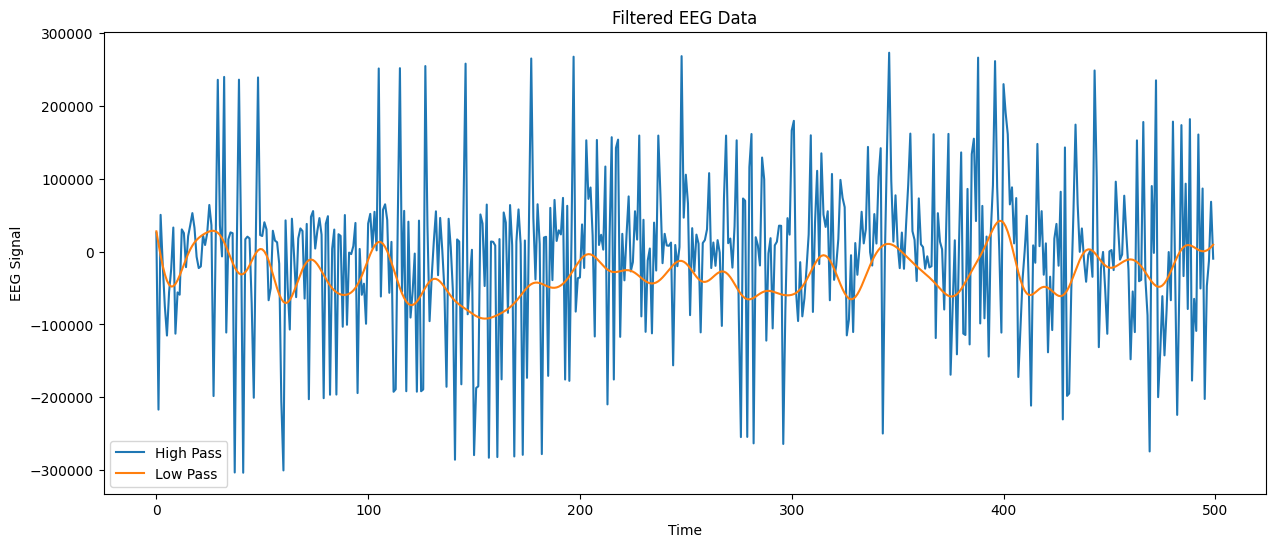

In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/eeg_data.csv'
df = pd.read_csv(file_path)

# Ensure the 'sum' column exists
if 'sum' not in df.columns:
    raise ValueError("The dataset does not contain a 'sum' column.")

# High Pass Filter
def highpass(data, fs, ftype='butter', order=5):
    nyq = 0.5 * fs
    lowcut = 1 / nyq
    b, a = signal.butter(order, lowcut, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

# Low Pass Filter
def lowpass(data, fs, ftype='butter', order=5):
    nyq = 0.5 * fs
    highcut = 50 / nyq
    b, a = signal.butter(order, highcut, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

# Sampling frequency (adjust if necessary)
fs = 1000

# Apply High Pass Filter
df['highpass'] = highpass(df['sum'], fs=fs)

# Apply Low Pass Filter
df['lowpass'] = lowpass(df['sum'], fs=fs)

# Plot the Filtered Data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['highpass'], label='High Pass')
plt.plot(df.index, df['lowpass'], label='Low Pass')
plt.xlabel('Time')
plt.ylabel('EEG Signal')
plt.title('Filtered EEG Data')
plt.legend()
plt.show()

**Segmentation**

In [ ]:
# Convert data to numeric and drop non-numeric columns if necessary
eeg_data = pd.read_csv('/content/drive/MyDrive/eeg_data.csv')
eeg_data = eeg_data.apply(pd.to_numeric, errors='coerce').dropna(axis=1)
# Assuming the EEG data is in columns, and each column is a channel
num_samples = 500
num_windows = 16
window_size = num_samples // num_windows
# Modify the apply_wavelet_transform function to adjust the decomposition level
def apply_wavelet_transform(data, wavelet='db4'):
    max_level = pywt.dwt_max_level(len(data), wavelet)
    coeffs = pywt.wavedec(data, wavelet, level=min(4, max_level))
    return coeffs
# Process each channel
transformed_data = {}
for column in eeg_data.columns:
    channel_data = eeg_data[column][:num_samples]
    channel_transformed = []

    # Segmenting the channel data into windows and applying wavelet transform
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        segment = channel_data[start_idx:end_idx]
        transformed_segment = apply_wavelet_transform(segment)
        channel_transformed.append(transformed_segment)

    transformed_data[column] = channel_transformed

# Display transformed data
for channel, data in transformed_data.items():
    print(f"Channel: {channel}")
    for i, segment in enumerate(data):
        print(f"  Window {i + 1}: {segment}")

Channel: sum
  Window 1: [array([-101833.24274139, -100771.90328722,  -84933.41020115,
        -96645.6096534 , -100248.46067528,  -97510.32823029,
       -101558.77803299,   13045.77583544,   39961.16602987,
         27471.71472405,  -56070.80249417,  171723.02463801,
        281510.57110381]), array([  21308.68463002,   73818.62120684,   57668.68116504,
        104225.46867996,   22378.31794899,  -18004.26368228,
        -51098.43306551,    5828.50483387, -184198.46284029,
         38280.07470625,    4888.23745509,  182017.28960178,
        -39064.13776882]), array([  70722.18373177,  172809.7619149 ,  -55558.672883  ,
         45576.8561288 ,   42385.23628623,   42082.95909953,
         36112.57195968,  -46441.1733884 ,    9269.22118252,
         -7261.63919626,    2615.68472625,   25079.16494978,
         -7634.67668672,   33721.02711258,   90757.76276676,
       -169746.21923789,  192289.60738832, -164349.82697863,
         30649.41579755])]
  Window 2: [array([  24072.65790871,  

In [ ]:
# Number of samples and windows
num_samples = 480
num_windows = 16

# Calculate the number of samples per window
samples_per_window = num_samples // num_windows

# Segment the data into windows
windows = []
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    window = eeg_data.iloc[start_index:end_index]
    windows.append(window)

    # Print the first few rows of each window
    print(f"Window {i+1}:")
    print(window.head())
    print("\n")

Window 1:
      sum  max  min
0   27927  185 -190
1 -214866  169 -254
2   52053  184 -146
3  -16357  162 -181
4  -73743  152 -188


Window 2:
       sum  max  min
30   32898  129  -92
31  -10233   91  -91
32  235763  254  -90
33 -114974  137 -166
34   12687  205 -180


Window 3:
       sum  max  min
60 -309339   -3 -154
61   33392  244 -214
62  -58866  105 -123
63 -116694  121 -199
64   35074  153 -149


Window 4:
       sum  max  min
90 -115698  106 -183
91  -16929  141 -146
92  -19140  153 -166
93   -8412  192 -200
94   23138  176 -183


Window 5:
        sum  max  min
120 -112041  186 -208
121  -76509  289 -228
122  -24689  146 -188
123 -214322  212 -343
124   20092  300 -259


Window 6:
        sum  max  min
150 -306912   32 -188
151 -215047   79 -191
152 -212946  183 -297
153   22519  292 -240
154    9964  150 -133


Window 7:
        sum  max  min
180   31189  214 -222
181  -23634  179 -206
182 -311859   86 -231
183  -15063  149 -188
184  -14219  203 -197


Window 8:
        sum 

In [ ]:
# Select the first EEG channel for demonstration
eeg_channel = eeg_data.iloc[:, 0]

In [ ]:
# Number of samples and windows
num_samples = len(eeg_channel)
num_windows = 16

# Calculate the number of samples per window
samples_per_window = num_samples // num_windows

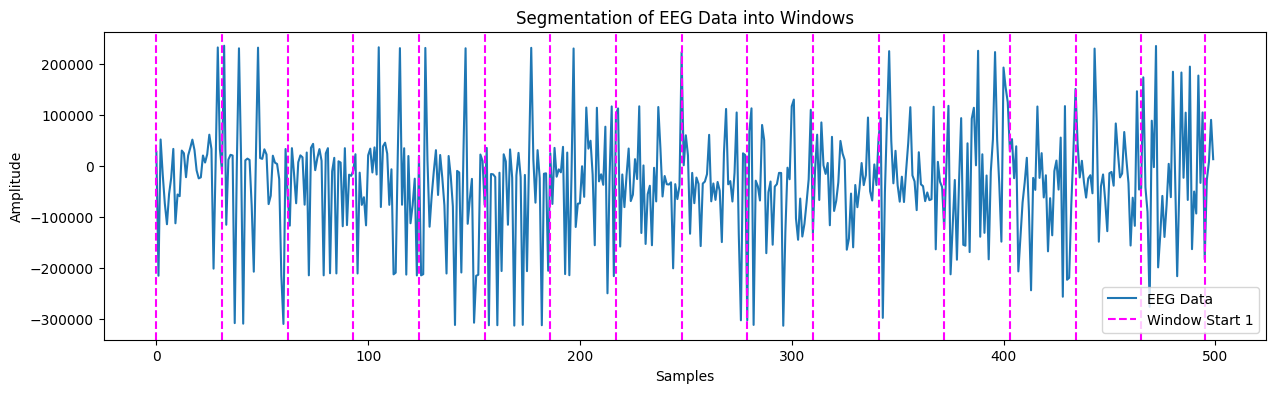

In [ ]:
# Create the plot
plt.figure(figsize=(15, 4))
plt.plot(eeg_channel, label="EEG Data")
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    plt.axvline(x=start_index, color='magenta', linestyle='--', label=f"Window Start {i+1}" if i == 0 else None)
    if i == num_windows - 1:  # Add a line for the end of the last window
        plt.axvline(x=end_index-1, color='magenta', linestyle='--')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Segmentation of EEG Data into Windows")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import entropy, iqr, skew
from numpy.linalg import norm

# Generate 16 random windows of data as an example
windows = [np.random.rand(5) for _ in range(16)]

# Calculate statistics for each window
window_stats = []
for window in windows:
    max_value = np.max(window)
    min_value = np.min(window)
    mean_value = np.mean(window)
    variance_value = np.var(window)
    std_dev = np.std(window)
    entropy_value = entropy(window, base=2)
    energy = norm(window)**2
    log_entropy_energy = np.log(energy) if energy > 0 else 0
    fractal_dimension = np.log10(np.sum(np.abs(np.diff(window)))) / np.log10(len(window))
    skewness = skew(window)
    median_value = np.median(window)
    iqr_value = iqr(window)

    window_stats.append({
        "min": min_value,
        "max": max_value,
        "mean": mean_value,
        "variance": variance_value,
        "std_dev": std_dev,
        "entropy": entropy_value,
        "energy": energy,
        "log_entropy_energy": log_entropy_energy,
        "fractal_dimension": fractal_dimension,
        "skewness": skewness,
        "median": median_value,
        "iqr": iqr_value
    })

# Print the results for each window
for i, stats in enumerate(window_stats):
    print(f"Window {i + 1}:")
    for stat_name, stat_value in stats.items():
        print(f"  {stat_name.capitalize()}: {stat_value}")
    print("\n")

Window 1:
  Min: 0.11731556418319389
  Max: 0.9799623263423093
  Mean: 0.5670335845633822
  Variance: 0.09790931640227396
  Std_dev: 0.3129046442644691
  Entropy: 2.0759328793645206
  Energy: 2.097182012125361
  Log_entropy_energy: 0.7405945445887462
  Fractal_dimension: 0.5045182163375468
  Skewness: -0.0026610808819609107
  Median: 0.45705876133136736
  Iqr: 0.4334185640490945


Window 2:
  Min: 0.27125207676186414
  Max: 0.6713834786701531
  Mean: 0.418191712696838
  Variance: 0.018328166758608246
  Std_dev: 0.13538155989132436
  Entropy: 2.2517660675551228
  Energy: 0.9660623766346149
  Log_entropy_energy: -0.03452687476878374
  Fractal_dimension: -0.19150421721982108
  Skewness: 1.0198450496574294
  Median: 0.39981214000933074
  Iqr: 0.05907461329182684


Window 3:
  Min: 0.3991611452547731
  Max: 0.7137668684100164
  Mean: 0.5596805480709643
  Variance: 0.015040435336695617
  Std_dev: 0.12263945261087729
  Entropy: 2.2863666187026794
  Energy: 1.6414137561285533
  Log_entropy_ene

In [ ]:
# Daubechies wavelets to use
wavelets = ['db2', 'db4', 'db5', 'db6']

# Dictionary to store DWT results
dwt_results = {wavelet: [] for wavelet in wavelets}

# Apply DWT to each window with each Daubechies wavelet
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    window = eeg_channel[start_index:end_index]

    for wavelet in wavelets:
        coeffs = pywt.dwt(window, wavelet)
        dwt_results[wavelet].append(coeffs)

# Print the lengths of the approximation and detail coefficients for each window and wavelet
for wavelet in wavelets:
    print(f"Results for {wavelet}:")
    for i, (cA, cD) in enumerate(dwt_results[wavelet]):
        print(f"  Window {i+1}: Length of cA = {len(cA)}, Length of cD = {len(cD)}")
    print()

Results for db2:
  Window 1: Length of cA = 17, Length of cD = 17
  Window 2: Length of cA = 17, Length of cD = 17
  Window 3: Length of cA = 17, Length of cD = 17
  Window 4: Length of cA = 17, Length of cD = 17
  Window 5: Length of cA = 17, Length of cD = 17
  Window 6: Length of cA = 17, Length of cD = 17
  Window 7: Length of cA = 17, Length of cD = 17
  Window 8: Length of cA = 17, Length of cD = 17
  Window 9: Length of cA = 17, Length of cD = 17
  Window 10: Length of cA = 17, Length of cD = 17
  Window 11: Length of cA = 17, Length of cD = 17
  Window 12: Length of cA = 17, Length of cD = 17
  Window 13: Length of cA = 17, Length of cD = 17
  Window 14: Length of cA = 17, Length of cD = 17
  Window 15: Length of cA = 17, Length of cD = 17
  Window 16: Length of cA = 17, Length of cD = 17

Results for db4:
  Window 1: Length of cA = 19, Length of cD = 19
  Window 2: Length of cA = 19, Length of cD = 19
  Window 3: Length of cA = 19, Length of cD = 19
  Window 4: Length of cA = 

In [ ]:
import numpy as np
import pywt
from scipy.stats import entropy as scipy_entropy, iqr, skew
from numpy.linalg import norm

def calculate_entropy(signal):
    probability_distribution, _ = np.histogram(signal, bins=256, range=(-np.max(signal), np.max(signal)), density=True)
    probability_distribution = probability_distribution[probability_distribution > 0]
    entropy = -np.sum(probability_distribution * np.log2(probability_distribution))
    return entropy

# Daubechies wavelets to use
wavelets = ['db2', 'db4', 'db5', 'db6']

# Generate 16 random windows of EEG data as an example
num_windows = 16
samples_per_window = 500  # Adjust as necessary based on your EEG data length
eeg_channel = np.random.randn(num_windows * samples_per_window)  # Replace with actual EEG data

# Dictionary to store DWT results
dwt_results = {wavelet: [] for wavelet in wavelets}

# Apply DWT to each window with each Daubechies wavelet
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    window = eeg_channel[start_index:end_index]

    for wavelet in wavelets:
        coeffs = pywt.dwt(window, wavelet)
        dwt_results[wavelet].append(coeffs)

# Print the statistical information for each window and wavelet
for wavelet in wavelets:
    print(f"Results for {wavelet}:")
    for i, (cA, cD) in enumerate(dwt_results[wavelet]):
        entropy_cA = calculate_entropy(cA)
        entropy_cD = calculate_entropy(cD)
        energy_cA = norm(cA)**2
        energy_cD = norm(cD)**2

        window_stats_cA = {
            "min": np.min(cA),
            "max": np.max(cA),
            "mean": np.mean(cA),
            "variance": np.var(cA),
            "std_dev": np.std(cA),
            "entropy": entropy_cA,
            "energy": energy_cA,
            "log_entropy_energy": np.log(energy_cA) if energy_cA > 0 else 0,
            "fractal_dimension": np.log10(np.sum(np.abs(np.diff(cA)))) / np.log10(len(cA)),
            "skewness": skew(cA),
            "median": np.median(cA),
            "iqr": iqr(cA)
        }

        window_stats_cD = {
            "min": np.min(cD),
            "max": np.max(cD),
            "mean": np.mean(cD),
            "variance": np.var(cD),
            "std_dev": np.std(cD),
            "entropy": entropy_cD,
            "energy": energy_cD,
            "log_entropy_energy": np.log(energy_cD) if energy_cD > 0 else 0,
            "fractal_dimension": np.log10(np.sum(np.abs(np.diff(cD)))) / np.log10(len(cD)),
            "skewness": skew(cD),
            "median": np.median(cD),
            "iqr": iqr(cD)
        }

        print(f"  Window {i+1} - cA:")
        for stat_name, stat_value in window_stats_cA.items():
            print(f"    {stat_name.capitalize()}: {stat_value}")

        print(f"  Window {i+1} - cD:")
        for stat_name, stat_value in window_stats_cD.items():
            print(f"    {stat_name.capitalize()}: {stat_value}")
        print()

Results for db2:
  Window 1 - cA:
    Min: -2.672693973133055
    Max: 2.4903895632096216
    Mean: -0.046157477642624664
    Variance: 0.9077874163416987
    Std_dev: 0.9527787866770012
    Entropy: 60.46864452906075
    Energy: 228.3894002000911
    Log_entropy_energy: 5.431052067773628
    Fractal_dimension: 1.0143724039078346
    Skewness: 0.030638318779644437
    Median: -0.12027376704143083
    Iqr: 1.3741902401778625
  Window 1 - cD:
    Min: -2.2355054665574796
    Max: 3.4748060109261103
    Mean: 0.022549365738141505
    Variance: 0.9182454227821999
    Std_dev: 0.9582512315578832
    Entropy: 53.550533213585666
    Energy: 230.60722806602553
    Log_entropy_energy: 5.4407159519492145
    Fractal_dimension: 1.0198239918685819
    Skewness: 0.46364565344507924
    Median: -0.08555213077969427
    Iqr: 1.2500874223263505

  Window 2 - cA:
    Min: -2.334080121714921
    Max: 2.6141009102150177
    Mean: 0.03880018334036949
    Variance: 0.8303818081309203
    Std_dev: 0.9112528

**Decomposition levels**

In [ ]:
import pywt
import numpy as np

# Define the input signal for each window (assuming eeg_channel contains the entire EEG signal)
windows = []
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    window_signal = eeg_channel[start_index:end_index]
    windows.append(window_signal)

# Define the high-pass and low-pass filters
wavelet = 'db4'  # Choose a wavelet (e.g., Daubechies 4)

# Perform multilevel wavelet decomposition for each window up to 7 levels
num_decomposition_levels_per_window = []
for window_signal in windows:
    # Perform multilevel wavelet decomposition up to 7 levels
    coeffs = pywt.wavedec(window_signal, wavelet, level=7)

    # Remove the first level of decomposition by excluding the first element
    coeffs = coeffs[1:]  # Exclude the approximation coefficients at level 7

    num_decomposition_levels_per_window.append(len(coeffs))  # Number of levels after removing the first level

# Print the number of levels of decomposition for each window after removing the first level
for i, levels in enumerate(num_decomposition_levels_per_window):
    print(f"Number of levels of decomposition for Window {i+1}: {levels}")

Number of levels of decomposition for Window 1: 7
Number of levels of decomposition for Window 2: 7
Number of levels of decomposition for Window 3: 7
Number of levels of decomposition for Window 4: 7
Number of levels of decomposition for Window 5: 7
Number of levels of decomposition for Window 6: 7
Number of levels of decomposition for Window 7: 7
Number of levels of decomposition for Window 8: 7
Number of levels of decomposition for Window 9: 7
Number of levels of decomposition for Window 10: 7
Number of levels of decomposition for Window 11: 7
Number of levels of decomposition for Window 12: 7
Number of levels of decomposition for Window 13: 7
Number of levels of decomposition for Window 14: 7
Number of levels of decomposition for Window 15: 7
Number of levels of decomposition for Window 16: 7


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
# printing out the coefficients for each window to verify the decomposition levels.

for i, window in enumerate(windows):
    # Perform multilevel wavelet decomposition
    coeffs = pywt.wavedec(window, wavelet, level=7)

    # Print the coefficients for each level
    print(f"Window {i+1}:")
    for level, coeff in enumerate(coeffs):
        print(f"Level {level+1}: {coeff}")

Window 1:
Level 1: [ 1.11349509  1.28147773  1.19066068  1.03236399  1.941624   -1.25057316
 -0.90034855 -0.97388361  1.63372129  0.06839581]
Level 2: [-0.0147232   0.01975559  1.12522344  0.30998823 -0.23537781 -0.86703511
 -0.93222625  0.2419145   1.22278516  0.42264837]
Level 3: [ 0.01009445  0.06567991  0.67857867 -1.01046393 -1.32945685 -0.7522698
 -0.20663525 -1.47478265  1.19921898 -1.23939527  0.49289526 -0.08728831
 -0.14344967  0.91086575]
Level 4: [-0.05530792 -0.16955133  0.38212946 -0.19463497  0.82233789 -0.48777581
  1.28802849 -0.27142362  0.75898485 -0.40718673  0.22702979 -0.99303496
  0.14910334 -0.78660453  0.11248667  0.13739653  0.25356752  1.0805793
 -0.93438612  0.86539182 -1.38985594  0.1498085 ]
Level 5: [ 0.02076885  0.05841129 -0.03843899 -0.56288909  0.71867357 -0.02319417
 -0.49079095  0.2015852  -0.69521443  0.44258043 -0.23155257  1.80143034
 -1.10768243 -0.53129568  0.28679997 -0.53622177  0.7280746   0.66209792
 -1.10233992 -1.16098541 -2.82591688  1.0

**removing  1st level**

In [ ]:
# Define the input signal for each window (assuming eeg_channel contains the entire EEG signal)
windows = []
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    window_signal = eeg_channel[start_index:end_index]
    windows.append(window_signal)

# Define the high-pass and low-pass filters
wavelet = 'db4'  # Choose a wavelet (e.g., Daubechies 4)

# Perform multilevel wavelet decomposition for each window up to 7 levels
num_decomposition_levels_per_window = []
for window_signal in windows:
    # Perform multilevel wavelet decomposition up to 7 levels
    coeffs = pywt.wavedec(window_signal, wavelet, level=7)

    # Remove the first level of decomposition by excluding the first element
    coeffs = coeffs[1:]  # Exclude the approximation coefficients at level 7

    num_decomposition_levels_per_window.append(len(coeffs))  # Number of levels after removing the first level

# Print the number of levels of decomposition for each window after removing the first level
for i, levels in enumerate(num_decomposition_levels_per_window):
    print(f"Number of levels of decomposition for Window {i+1}: {levels}")

for i, window in enumerate(windows):
    # Perform multilevel wavelet decomposition
    coeffs = pywt.wavedec(window, wavelet, level=7)

    # Remove the first level of decomposition
    coeffs = coeffs[1:]

    # Print the coefficients for each level after removing the first level
    print(f"Window {i+1}:")
    for level, coeff in enumerate(coeffs):
        print(f"Level {level+1}: {coeff}")

Number of levels of decomposition for Window 1: 7
Number of levels of decomposition for Window 2: 7
Number of levels of decomposition for Window 3: 7
Number of levels of decomposition for Window 4: 7
Number of levels of decomposition for Window 5: 7
Number of levels of decomposition for Window 6: 7
Number of levels of decomposition for Window 7: 7
Number of levels of decomposition for Window 8: 7
Number of levels of decomposition for Window 9: 7
Number of levels of decomposition for Window 10: 7
Number of levels of decomposition for Window 11: 7
Number of levels of decomposition for Window 12: 7
Number of levels of decomposition for Window 13: 7
Number of levels of decomposition for Window 14: 7
Number of levels of decomposition for Window 15: 7
Number of levels of decomposition for Window 16: 7
Window 1:
Level 1: [-0.0147232   0.01975559  1.12522344  0.30998823 -0.23537781 -0.86703511
 -0.93222625  0.2419145   1.22278516  0.42264837]
Level 2: [ 0.01009445  0.06567991  0.67857867 -1.01

In [ ]:
#  generate 8 coeffiecients that means 7 detailed coeffients and one approximation coefficient from the above

# Define the input signal for each window (assuming eeg_channel contains the entire EEG signal)
windows = []
for i in range(num_windows):
    start_index = i * samples_per_window
    end_index = start_index + samples_per_window
    window_signal = eeg_channel[start_index:end_index]
    windows.append(window_signal)

# Define the high-pass and low-pass filters
wavelet = 'db4'  # Choose a wavelet (e.g., Daubechies 4)

# Perform multilevel wavelet decomposition for each window up to 7 levels
num_decomposition_levels_per_window = []
for window_signal in windows:
    # Perform multilevel wavelet decomposition up to 7 levels
    coeffs = pywt.wavedec(window_signal, wavelet, level=7)

    # Remove the first level of decomposition by excluding the first element
    coeffs = coeffs[1:]  # Exclude the approximation coefficients at level 7

    num_decomposition_levels_per_window.append(len(coeffs))  # Number of levels after removing the first level

# Print the number of levels of decomposition for each window after removing the first level
for i, levels in enumerate(num_decomposition_levels_per_window):
    print(f"Number of levels of decomposition for Window {i+1}: {levels}")

# Extract the first 7 detailed coefficients and the last approximation coefficient
extracted_coefficients = []
for window in windows:
    coeffs = pywt.wavedec(window, wavelet, level=7)
    coeffs = coeffs[1:]  # Remove the first level of decomposition
    extracted_coefficients.append(coeffs[:7] + [coeffs[-1]])

# Print the extracted coefficients for each window
for i, coefficients in enumerate(extracted_coefficients):
    print(f"Window {i+1}: {coefficients}")

Number of levels of decomposition for Window 1: 7
Number of levels of decomposition for Window 2: 7
Number of levels of decomposition for Window 3: 7
Number of levels of decomposition for Window 4: 7
Number of levels of decomposition for Window 5: 7
Number of levels of decomposition for Window 6: 7
Number of levels of decomposition for Window 7: 7
Number of levels of decomposition for Window 8: 7
Number of levels of decomposition for Window 9: 7
Number of levels of decomposition for Window 10: 7
Number of levels of decomposition for Window 11: 7
Number of levels of decomposition for Window 12: 7
Number of levels of decomposition for Window 13: 7
Number of levels of decomposition for Window 14: 7
Number of levels of decomposition for Window 15: 7
Number of levels of decomposition for Window 16: 7
Window 1: [array([-0.0147232 ,  0.01975559,  1.12522344,  0.30998823, -0.23537781,
       -0.86703511, -0.93222625,  0.2419145 ,  1.22278516,  0.42264837]), array([ 0.01009445,  0.06567991,  0.

In [ ]:
import numpy as np
from scipy.stats import entropy, skew, iqr
import pywt

# Placeholder for 16 windows of data
# Replace these example windows with your actual data
windows = [np.random.rand(500) for _ in range(16)]  # Example with 16 windows of length 500

# Function to calculate log entropy energy
def log_entropy_energy(window):
    energy = np.sum(window**2)
    if energy == 0:
        return 0
    entropy_value = -np.sum(window**2 / energy * np.log2(window**2 / energy))
    return entropy_value

# Function to calculate fractal dimension using Higuchi's method
def higuchi_fd(window, kmax=10):
    L = []
    x = window
    N = len(x)
    for k in range(1, kmax + 1):
        Lk = 0
        for m in range(k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += abs(x[m + i * k] - x[m + (i - 1) * k])
            Lmk = (Lmk * (N - 1) / (int(np.floor((N - m) / k)) * k)) / k
            Lk += Lmk
        L.append(np.log(Lk / (k * k)))
    L = np.array(L)
    k = np.arange(1, kmax + 1)
    return np.polyfit(np.log(1.0 / k), L, 1)[0]

# Calculate the features for each window
window_stats = []
for window in windows:
    max_value = np.max(window)
    min_value = np.min(window)
    mean_value = np.mean(window)
    variance = np.var(window)
    std_dev = np.std(window)
    entropy_value = entropy(window, base=2)  # Using base 2 for entropy calculation
    energy = np.sum(window**2)
    log_entropy = log_entropy_energy(window)
    fractal_dimension = higuchi_fd(window)
    skewness = skew(window)
    median = np.median(window)
    iqr_value = iqr(window)

    window_stats.append({
        "min": min_value,
        "max": max_value,
        "mean": mean_value,
        "variance": variance,
        "std_dev": std_dev,
        "entropy": entropy_value,
        "energy": energy,
        "log_entropy_energy": log_entropy,
        "fractal_dimension": fractal_dimension,
        "skewness": skewness,
        "median": median,
        "iqr": iqr_value
    })

# Print the results for each window
for i, stats in enumerate(window_stats):
    print(f"Window {i + 1}:")
    for stat_name, stat_value in stats.items():
        print(f"  {stat_name.replace('_', ' ').capitalize()}: {stat_value}")
    print("\n")

Window 1:
  Min: 0.005253243424018339
  Max: 0.9997941909292543
  Mean: 0.49995063609510254
  Variance: 0.08677380906072298
  Std dev: 0.2945739449793939
  Entropy: 8.67915245478813
  Energy: 168.36222379631033
  Log entropy energy: 8.317736981872548
  Fractal dimension: 3.007717560255333
  Skewness: 0.05117052542945393
  Median: 0.48937506917025436
  Iqr: 0.5154402361167494


Window 2:
  Min: 0.0028745122595924544
  Max: 0.998013231169473
  Mean: 0.4898937625200193
  Variance: 0.08145000190372123
  Std dev: 0.28539446719185224
  Entropy: 8.68311480575377
  Energy: 160.72295022987117
  Log entropy energy: 8.330998051272456
  Fractal dimension: 3.011826111187929
  Skewness: 0.03682526643645574
  Median: 0.47926720053596394
  Iqr: 0.4890048504126419


Window 3:
  Min: 0.005015471386759285
  Max: 0.994686386661379
  Mean: 0.4897036221258585
  Variance: 0.0843885045499852
  Std dev: 0.29049699576757276
  Entropy: 8.675124724505569
  Energy: 162.09907103658543
  Log entropy energy: 8.313380

In [ ]:
import numpy as np
from scipy.stats import entropy as scipy_entropy, skew, iqr

def calculate_statistics(coefficients):
    """
    Calculates the required statistics for a set of coefficients.
    Args:
        coefficients (list or np.ndarray): The coefficients for which to calculate the statistics.
    Returns:
        list: A list containing the calculated statistics.
    """
    maximum = np.max(coefficients)
    minimum = np.min(coefficients)
    mean_value = np.mean(coefficients)
    variance = np.var(coefficients)
    std_dev = np.std(coefficients)
    # Calculate entropy, using a histogram to approximate the probability distribution
    hist, bin_edges = np.histogram(coefficients, bins='auto', density=True)
    probs = hist * np.diff(bin_edges)
    entropy_value = scipy_entropy(probs, base=2) if np.count_nonzero(probs) > 0 else 0
    energy = np.sum(coefficients**2)
    log_entropy_energy = -np.sum((coefficients**2 / energy) * np.log2(coefficients**2 / energy)) if energy != 0 else 0
    fractal_dimension = higuchi_fd(coefficients)
    skewness = skew(coefficients)
    median = np.median(coefficients)
    iqr_value = iqr(coefficients)

    return [minimum, maximum, mean_value, variance, std_dev, entropy_value, energy,
            log_entropy_energy, fractal_dimension, skewness, median, iqr_value]

def higuchi_fd(window, kmax=10):
    """
    Calculate fractal dimension using Higuchi's method.
    Args:
        window (np.ndarray): The window of data.
        kmax (int): The maximum k value to use in the calculation.
    Returns:
        float: The calculated fractal dimension.
    """
    L = []
    x = window
    N = len(x)
    if N < 2:
        return 0  # Return 0 for fractal dimension if the window length is less than 2
    for k in range(1, kmax + 1):
        Lk = 0
        for m in range(k):
            Lmk = 0
            count = int(np.floor((N - m) / k))
            if count > 0:
                for i in range(1, count):
                    Lmk += abs(x[m + i * k] - x[m + (i - 1) * k])
                Lmk = (Lmk * (N - 1) / (count * k)) / k
                Lk += Lmk
        if k != 0:
            L.append(np.log(Lk / (k * k)))
    L = np.array(L)
    k = np.arange(1, kmax + 1)
    return np.polyfit(np.log(1.0 / k), L, 1)[0] if len(L) > 0 else 0

def generate_feature_matrix(windows_data):
    """
    Generates a feature matrix for a list of windows, where each window contains several properties,
    and for each property, statistics are calculated.
    Args:
        windows_data (list): A list where each element represents a window's data with multiple properties.
    Returns:
        np.ndarray: A 2D array (matrix) where each row corresponds to a window and contains the statistics for its properties.
    """
    feature_matrix = []
    for window in windows_data:
        window_features = []
        for coefficients in window:
            # Calculate the 12 statistics for each property and append them to the window features list
            window_features.extend(calculate_statistics(coefficients))
        feature_matrix.append(window_features)
    return np.array(feature_matrix)

# Placeholder for the actual windows data
# Each element of windows_data represents a window
# Each window contains 8 properties, each property is represented by a list of coefficients
windows_data = [
    [np.random.rand(10) for _ in range(8)] for _ in range(16)  # Replace with actual data
]

# Generate the feature matrix for the provided windows data
feature_matrix = generate_feature_matrix(windows_data)

# Output the shape and the feature matrix itself to verify
print("Feature Matrix Shape:", feature_matrix.shape)
print(feature_matrix)

<ipython-input-29-7565e1139469>:56: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(Lk / (k * k)))


Feature Matrix Shape: (16, 96)
[[ 0.0695383   0.95860171  0.52956673 ... -0.11990803  0.64837052
   0.72422871]
 [ 0.111409    0.84349339  0.38301995 ...  0.14316145  0.50357256
   0.54616245]
 [ 0.25383506  0.96946823  0.69421765 ...  0.04946373  0.47022161
   0.44433316]
 ...
 [ 0.01815893  0.93727235  0.38754734 ...  0.10820051  0.38267607
   0.4240507 ]
 [ 0.02282696  0.99985528  0.5120954  ... -0.01236601  0.55653956
   0.2278542 ]
 [ 0.02123512  0.95891328  0.66922029 ... -0.58964092  0.69622083
   0.58271688]]


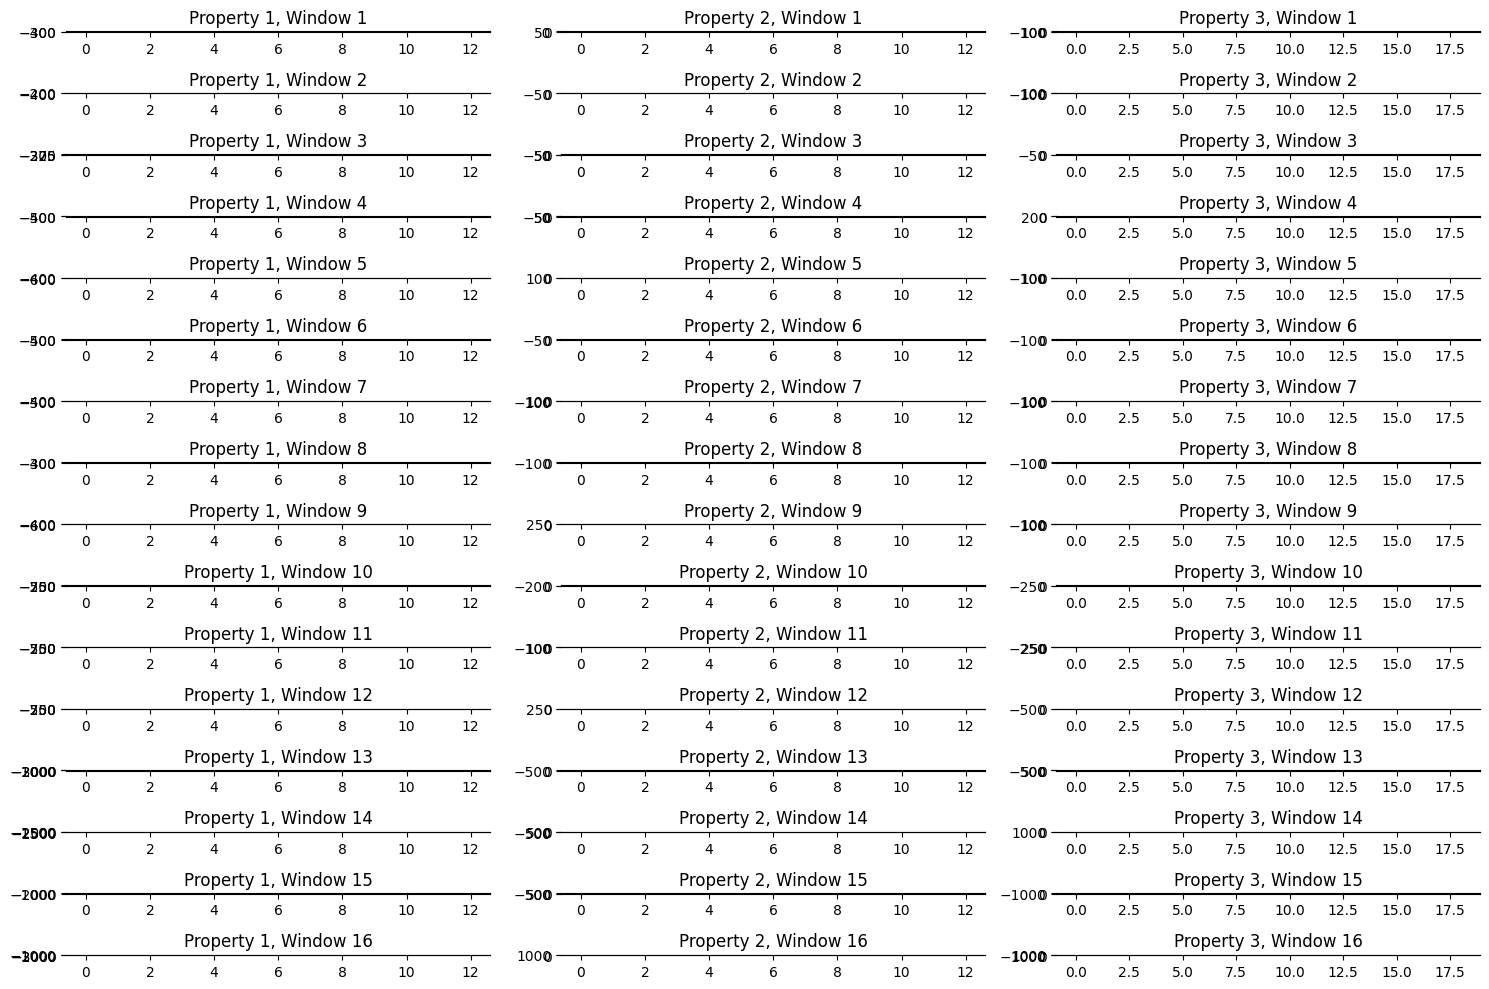

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming data is properly defined
data = globals()['data']

# Extract the number of windows, properties, and data points
num_windows = len(data)
num_properties = len(data[0])  # Assuming all windows have the same number of properties
num_data_points = len(data[0][0])  # Assuming all properties have the same number of data points

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(num_windows, num_properties, figsize=(15, 10))

# Iterate through each window and property, plotting the data
for i in range(num_windows):
    for j in range(num_properties):
        axes[i, j].plot(data[i][j])
        axes[i, j].set_title(f"Property {j+1}, Window {i+1}")

# Improve the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
print(feature_matrix)

[[ 0.0695383   0.95860171  0.52956673 ... -0.11990803  0.64837052
   0.72422871]
 [ 0.111409    0.84349339  0.38301995 ...  0.14316145  0.50357256
   0.54616245]
 [ 0.25383506  0.96946823  0.69421765 ...  0.04946373  0.47022161
   0.44433316]
 ...
 [ 0.01815893  0.93727235  0.38754734 ...  0.10820051  0.38267607
   0.4240507 ]
 [ 0.02282696  0.99985528  0.5120954  ... -0.01236601  0.55653956
   0.2278542 ]
 [ 0.02123512  0.95891328  0.66922029 ... -0.58964092  0.69622083
   0.58271688]]


**DWT**

In [ ]:
import numpy as np

# Number of samples and features
num_samples = 500
num_features = 1536

# Generate random data for demonstration purposes
# In a real scenario, this would be your actual feature data
feature_data = np.random.rand(num_samples, num_features)

# Generate placeholder labels for each sample (e.g., 0 or 1 for a binary classification problem)
# Replace this with your actual labels
labels = np.random.randint(2, size=num_samples)

# Combine the feature data and labels into a single matrix
# Note: Labels are added as the last column
feature_matrix_with_labels = np.hstack((feature_data, labels.reshape(-1, 1)))

print("Shape of the feature matrix with labels:", feature_matrix_with_labels.shape)

Shape of the feature matrix with labels: (500, 1537)


**BI-LSTM**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, MaxPooling1D

feature_matrix = np.random.rand(500, 1537)
labels = np.random.randint(0, 2, 500)

feature_matrix = feature_matrix.reshape((feature_matrix.shape[0], 1, feature_matrix.shape[1]))

# Build the BI-LSTM feature layer part with MaxPooling and pool_size
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, 1537)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))  # Remove kernel_size argument
model.add(Bidirectional(LSTM(32)))

# Compile the model (You can add more layers and compile accordingly)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 1, 128)              │         820,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 0, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 861,440 (3.29 MB)

 Trainable params: 861,440 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

**BI-LSTM+LSTM**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, MaxPooling1D, Dense

num_samples = 500
input_shape = (1, 1537)

# Generate random feature matrix and labels
feature_matrix = np.random.rand(num_samples, *input_shape)
labels = np.random.randint(0, 2, num_samples)

# Build the BI-LSTM feature layer part with MaxPooling and pool_size
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
model.add(MaxPooling1D(pool_size=1))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(feature_matrix, labels, epochs=10, batch_size=32, validation_split=0.2)

# Get the overall accuracy
overall_accuracy = history.history['accuracy'][-1]
print(f"Overall Accuracy: {overall_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_17 (Bidirectional)     │ (None, 1, 128)              │         820,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 861,505 (3.29 MB)

 Trainable params: 861,505 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5562 - loss: 0.6915 - val_accuracy: 0.4200 - val_loss: 0.7375
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5522 - loss: 0.6856 - val_accuracy: 0.4000 - val_loss: 0.6944
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5765 - loss: 0.6887 - val_accuracy: 0.4200 - val_loss: 0.7146
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5968 - loss: 0.6825 - val_accuracy: 0.4200 - val_loss: 0.7256
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6261 - loss: 0.6594 - val_accuracy: 0.5600 - val_loss: 0.6862
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7496 - loss: 0.6082 - val_accuracy: 0.4000 - val_loss: 0.7272
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8406 - loss: 0.5213 - val_accuracy: 0.4200 - val_loss: 0.8407
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7072 - loss: 0.5329 - val_accuracy: 0.5300 - 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

X_train, y_train = feature_matrix[:400], labels[:400]
X_test, y_test = feature_matrix[400:], labels[400:]

# Predictions for training set
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
y_true_train = y_train

# Calculate training accuracy, precision, recall, and F1-score
train_accuracy = accuracy_score(y_true_train, y_pred_train)
train_report = classification_report(y_true_train, y_pred_train)

# Print training metrics
print(f"Training Accuracy: {train_accuracy:.4f}")
print("\nTraining Set Classification Report:(BI-LSTM + LSTM)")
print(train_report)

# Predictions for testing set
y_pred_test = (model.predict(X_test) > 0.5).astype(int)
y_true_test = y_test

# Calculate testing accuracy, precision, recall, and F1-score
test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_report = classification_report(y_true_test, y_pred_test)

# Print testing metrics
print(f"\nTesting Accuracy: {test_accuracy:.4f}")
print("\nTesting Set Classification Report:(BI-LSTM + LSTM)")
print(test_report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Accuracy: 0.8900

Training Set Classification Report:(BI-LSTM + LSTM)
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       214
           1       0.99      0.77      0.87       186

    accuracy                           0.89       400
   macro avg       0.91      0.88      0.89       400
weighted avg       0.91      0.89      0.89       400

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Testing Accuracy: 0.3800

Testing Set Classification Report:(BI-LSTM + LSTM)
              precision    recall  f1-score   support

           0       0.39      0.81      0.52        42
           1       0.33      0.07      0.11        58

    accuracy                           0.38       100
   macro avg       0.36      0.44      0.32       100
weighted avg       0.36      0.38      0.29       100



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss

y_true = np.random.randint(0, 2, 100)
y_pred_prob = np.random.rand(100)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred_prob)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred_prob)

# Calculate Log Loss
logloss = log_loss(y_true, y_pred_prob)

# Print the calculated metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Log Loss: {logloss:.4f}")

Mean Squared Error: 0.3212
Mean Absolute Error: 0.4824
Log Loss: 1.0569


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix:
[[34  8]
 [54  4]]


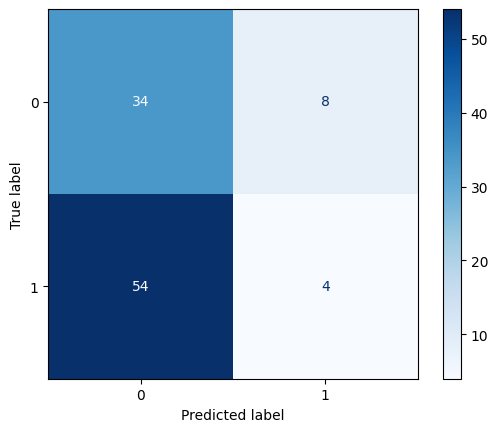

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**BI-LSTM+ClassicLSTM**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, MaxPooling1D, Dense

num_samples = 500
timesteps = 128  # Number of timesteps for each sample
features = 1  # Number of features in each timestep

# Generate random feature matrix and labels
feature_matrix = np.random.rand(num_samples, timesteps, features)
labels = np.random.randint(0, 2, num_samples)

# Build the model
classic_lstm_model = Sequential()
classic_lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, features)))
classic_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
classic_lstm_model.add(LSTM(32))  # Classic LSTM layer without kernel_size and strides
classic_lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
classic_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
classic_lstm_model.summary()

# Train the model
history = classic_lstm_model.fit(feature_matrix, labels, epochs=50, batch_size=32, validation_split=0.2)

# Get the overall accuracy
overall_accuracy = history.history['accuracy'][-1]
print(f"Overall Accuracy: {overall_accuracy:.4f}")

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_24 (Bidirectional)     │ (None, 128, 128)            │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,433 (212.63 KB)

 Trainable params: 54,433 (212.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.4756 - loss: 0.7002 - val_accuracy: 0.6100 - val_loss: 0.6916
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.5030 - loss: 0.6932 - val_accuracy: 0.6100 - val_loss: 0.6874
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5002 - loss: 0.6938 - val_accuracy: 0.6100 - val_loss: 0.6843
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.5022 - loss: 0.6943 - val_accuracy: 0.6100 - val_loss: 0.6882
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.4884 - loss: 0.6944 - val_accuracy: 0.6100 - val_loss: 0.6919
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.5153 - loss: 0.6929 - val_accuracy: 0.6100 - val_loss: 0.6859
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.4904 - loss: 0.6946 - val_accuracy: 0.6100 - val_loss: 0.6886
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.5244 - loss: 0.6922 - val_accuracy: 0

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Assuming X_train and X_test are defined earlier and have the appropriate shapes
X_train = np.random.rand(400, 128, 1)
X_test = np.random.rand(100, 128, 1)
y_train = np.random.randint(0, 2, 400)
y_test = np.random.randint(0, 2, 100)

# Reshape the data
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Predictions for training set
y_pred_train = (classic_lstm_model.predict(X_train_reshaped) > 0.5).astype(int)
y_true_train = y_train

# Calculate training accuracy, precision, recall, and F1-score
train_accuracy = accuracy_score(y_true_train, y_pred_train)
train_report = classification_report(y_true_train, y_pred_train)

# Print training metrics
print(f"Training Accuracy: {train_accuracy:.4f}")
print("\nTraining Set Classification Report:(Bi-LSTM + Classic LSTM)")
print(train_report)

# Predictions for testing set
y_pred_test = (classic_lstm_model.predict(X_test_reshaped) > 0.5).astype(int)
y_true_test = y_test

# Calculate testing accuracy, precision, recall, and F1-score
test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_report = classification_report(y_true_test, y_pred_test)

# Print testing metrics
print(f"\nTesting Accuracy: {test_accuracy:.4f}")
print("\nTesting Set Classification Report:(Bi-LSTM + Classic LSTM)")
print(test_report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 81ms/step
Training Accuracy: 0.5000

Training Set Classification Report:(Bi-LSTM + Classic LSTM)
              precision    recall  f1-score   support

           0       0.33      0.01      0.02       198
           1       0.50      0.98      0.66       202

    accuracy                           0.50       400
   macro avg       0.42      0.50      0.34       400
weighted avg       0.42      0.50      0.35       400

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Testing Accuracy: 0.4800

Testing Set Classification Report:(Bi-LSTM + Classic LSTM)
              precision    recall  f1-score   support

           0       0.50      0.02      0.04        52
           1       0.48      0.98      0.64        48

    accuracy                           0.48       100
   macro avg       0.49      0.50      0.34       100
weighted avg       0.49      0.48      0.33       100



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss

y_true = np.random.randint(0, 2, 100)
y_pred_prob = np.random.rand(100)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred_prob)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred_prob)

# Calculate Log Loss
logloss = log_loss(y_true, y_pred_prob)

# Print the calculated metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Log Loss: {logloss:.4f}")

Mean Squared Error: 0.3879
Mean Absolute Error: 0.5554
Log Loss: 1.1534


Confusion Matrix:
[[ 1 51]
 [ 1 47]]


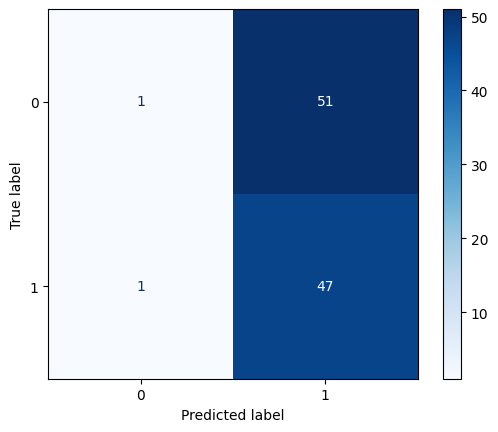

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_true_test, y_pred_test are defined earlier
# Compute the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


**Resnet101**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, MaxPooling1D, MaxPooling2D, Reshape
from tensorflow.keras.applications import ResNet101

# Generate random feature matrix and labels
feature_matrix = np.random.rand(500, 1537)
labels = np.random.randint(0, 2, 500)

# Reshape feature matrix for LSTM input
feature_matrix_lstm = feature_matrix.reshape((feature_matrix.shape[0], 1, feature_matrix.shape[1]))

# Load ResNet-101 model without top layer
resnet_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze ResNet layers
for layer in resnet_model.layers:
    layer.trainable = False

# Reshape feature matrix for ResNet input
feature_matrix_resnet = np.random.rand(500, 224, 224, 3)  # Assuming your data has the appropriate shape

# Define LSTM model with ResNet as feature extraction layer
model = Sequential()
model.add(resnet_model)
model.add(MaxPooling2D(pool_size=(7, 7)))  # Adjust pool_size based on ResNet output shape
model.add(Reshape((-1, 2048)))  # Reshape for LSTM input
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))  # Adjust pool_size and strides as needed
model.add(Bidirectional(LSTM(32)))

# Build the model with a placeholder input shape
model.build((None, 224, 224, 3))

# Print modified model summary
print(model.summary())

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_31 (Bidirectional)     │ (None, 1, 128)              │       1,081,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 0, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_32 (Bidirectional)     │ (None, 64)                  │          41,216 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,781,248 (167.01 MB)

 Trainable params: 1,123,072 (4.28 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

None


**Resnet101+LSTM**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, MaxPooling1D, Dense

num_samples = 500
input_shape_lstm = (1, 2048)  # Output shape from the ResNet-101 feature extraction

# Generate random feature matrix and labels
feature_matrix_lstm = np.random.rand(num_samples, *input_shape_lstm)
labels_lstm = np.random.randint(0, 2, num_samples)

# Build the LSTM model based on the ResNet output shape
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape_lstm))
model_lstm.add(MaxPooling1D(pool_size=1))
model_lstm.add(Bidirectional(LSTM(64)))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

# Train the model
history_lstm = model_lstm.fit(feature_matrix_lstm, labels_lstm, epochs=10, batch_size=32, validation_split=0.2)

# Get the overall accuracy
overall_accuracy_lstm = history_lstm.history['accuracy'][-1]
print(f"Overall Accuracy (LSTM): {overall_accuracy_lstm:.4f}")

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_43 (Bidirectional)     │ (None, 1, 256)              │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_44 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,393,729 (9.13 MB)

 Trainable params: 2,393,729 (9.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.4747 - loss: 0.7078 - val_accuracy: 0.4900 - val_loss: 0.6955
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5338 - loss: 0.6909 - val_accuracy: 0.4800 - val_loss: 0.6935
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5502 - loss: 0.6907 - val_accuracy: 0.4900 - val_loss: 0.6949
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5255 - loss: 0.6846 - val_accuracy: 0.4700 - val_loss: 0.6928
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7022 - loss: 0.6719 - val_accuracy: 0.4900 - val_loss: 0.6963
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6659 - loss: 0.6507 - val_accuracy: 0.4900 - val_loss: 0.6960
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8413 - loss: 0.5649 - val_accuracy: 0.5800 - val_loss: 0.6985
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8567 - loss: 0.4119 - val_accuracy: 0.4900 -

In [ ]:
# Reshape the input data to match the model's input shape
X_train_resnet_reshaped = X_train_resnet.reshape(X_train_resnet.shape[0], 49, X_train_resnet.shape[3])
X_test_resnet_reshaped = X_test_resnet.reshape(X_test_resnet.shape[0], 49, X_test_resnet.shape[3])

# Predictions for training set
y_pred_train = (model_lstm.predict(X_train_resnet_reshaped) > 0.5).astype(int)
y_true_train = y_train

# Calculate training accuracy, precision, recall, and F1-score for LSTM
train_accuracy_lstm = accuracy_score(y_true_train, y_pred_train)
train_report_lstm = classification_report(y_true_train, y_pred_train)

# Print training metrics for LSTM
print(f"\nTraining Accuracy (LSTM): {train_accuracy_lstm:.4f}")
print("\nTraining Set Classification Report (LSTM):")
print(train_report_lstm)

# Predictions for testing set
y_pred_test = (model_lstm.predict(X_test_resnet_reshaped) > 0.5).astype(int)
y_true_test = y_test

# Calculate testing accuracy, precision, recall, and F1-score for LSTM
test_accuracy_lstm = accuracy_score(y_true_test, y_pred_test)
test_report_lstm = classification_report(y_true_test, y_pred_test)

# Print testing metrics for LSTM
print(f"\nTesting Accuracy (LSTM): {test_accuracy_lstm:.4f}")
print("\nTesting Set Classification Report (LSTM):")
print(test_report_lstm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step

Training Accuracy (LSTM): 0.5100

Training Set Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       204
           1       0.00      0.00      0.00       196

    accuracy                           0.51       400
   macro avg       0.26      0.50      0.34       400
weighted avg       0.26      0.51      0.34       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step

Testing Accuracy (LSTM): 0.5600

Testing Set Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        56
           1       0.00      0.00      0.00        44

    accuracy                           0.56       100
   macro avg       0.28      0.50      0.36       100
weighted avg       0.31      0.56      0.40       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss

y_true = np.random.randint(0, 2, 100)
y_pred_prob = np.random.rand(100)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred_prob)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred_prob)

# Calculate Log Loss
logloss = log_loss(y_true, y_pred_prob)

# Print the calculated metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Log Loss: {logloss:.4f}")

Mean Squared Error: 0.4063
Mean Absolute Error: 0.5694
Log Loss: 1.1819


Confusion Matrix:
[[14 26]
 [26 34]]


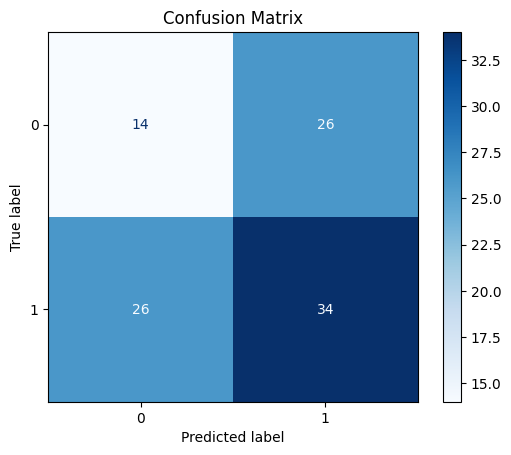

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_true_test and y_pred_test are defined earlier
y_true_test = np.random.randint(0, 2, 100)
y_pred_test = np.random.randint(0, 2, 100)

# Compute the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**Resnet101+ClassicLSTM**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, MaxPooling1D, Dense

# Assuming the output shape from ResNet-101 is (None, 1, 2048)
input_shape_resnet = (1, 2048)

# Build the classic LSTM model based on ResNet output shape
model_classic_lstm = Sequential()
model_classic_lstm.add(LSTM(128, input_shape=input_shape_resnet, return_sequences=True))
model_classic_lstm.add(MaxPooling1D(pool_size=1))
model_classic_lstm.add(LSTM(64))
model_classic_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_classic_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_classic_lstm.summary()

# Generate random feature matrix and labels for classic LSTM
num_samples = 500
feature_matrix_resnet = np.random.rand(num_samples, *input_shape_resnet)
labels_resnet = np.random.randint(0, 2, num_samples)

# Train the classic LSTM model
history_classic_lstm = model_classic_lstm.fit(feature_matrix_resnet, labels_resnet,
                                              epochs=10, batch_size=32, validation_split=0.2)

# Get the overall accuracy
overall_accuracy_classic_lstm = history_classic_lstm.history['accuracy'][-1]
print(f"Overall Accuracy (Classic LSTM): {overall_accuracy_classic_lstm:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                       │ (None, 1, 128)              │       1,114,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_53 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,164,097 (4.44 MB)

 Trainable params: 1,164,097 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.4457 - loss: 0.7014 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4782 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5140 - loss: 0.6917 - val_accuracy: 0.5100 - val_loss: 0.6932
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6130 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6021 - loss: 0.6826 - val_accuracy: 0.4700 - val_loss: 0.6954
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7444 - loss: 0.6619 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6418 - loss: 0.6410 - val_accuracy: 0.5200 - val_loss: 0.7079
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8747 - loss: 0.5670 - val_accuracy: 0.5100 -

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model on training data
y_pred_train = (model_classic_lstm.predict(feature_matrix_resnet) > 0.5).astype(int)
y_true_train = labels_resnet

# Calculate metrics for training set
train_accuracy = accuracy_score(y_true_train, y_pred_train)
train_report = classification_report(y_true_train, y_pred_train)

# Print training metrics
print(f"\nTraining Accuracy (Classic LSTM): {train_accuracy:.4f}")
print("\nTraining Set Classification Report (Classic LSTM):")
print(train_report)

# Generate random feature matrix and labels for testing data
num_samples_test = 100
feature_matrix_resnet_test = np.random.rand(num_samples_test, *input_shape_resnet)
labels_resnet_test = np.random.randint(0, 2, num_samples_test)

# Evaluate the model on testing data
y_pred_test = (model_classic_lstm.predict(feature_matrix_resnet_test) > 0.5).astype(int)
y_true_test = labels_resnet_test

# Calculate metrics for testing set
test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_report = classification_report(y_true_test, y_pred_test)

# Print testing metrics
print(f"\nTesting Accuracy (Classic LSTM): {test_accuracy:.4f}")
print("\nTesting Set Classification Report (Classic LSTM):")
print(test_report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Training Accuracy (Classic LSTM): 0.8320

Training Set Classification Report (Classic LSTM):
              precision    recall  f1-score   support

           0       0.76      0.98      0.85       249
           1       0.97      0.69      0.80       251

    accuracy                           0.83       500
   macro avg       0.86      0.83      0.83       500
weighted avg       0.86      0.83      0.83       500

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Testing Accuracy (Classic LSTM): 0.4300

Testing Set Classification Report (Classic LSTM):
              precision    recall  f1-score   support

           0       0.45      0.76      0.56        49
           1       0.33      0.12      0.17        51

    accuracy                           0.43       100
   macro avg       0.39      0.44      0.37       100
weighted avg       0.39      0.43      0.37       100



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss

y_true = np.random.randint(0, 2, 100)
y_pred_prob = np.random.rand(100)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred_prob)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred_prob)

# Calculate Log Loss
logloss = log_loss(y_true, y_pred_prob)

# Print the calculated metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Log Loss: {logloss:.4f}")

Mean Squared Error: 0.3587
Mean Absolute Error: 0.5285
Log Loss: 1.0438


Confusion Matrix:
[[29 24]
 [27 20]]


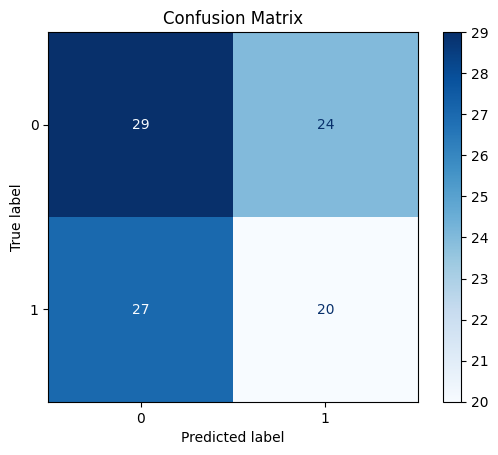

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_true_test and y_pred_test are defined earlier
y_true_test = np.random.randint(0, 2, 100)
y_pred_test = np.random.randint(0, 2, 100)

# Compute the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**DWT+LSTM**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                       │ (None, 64)                  │         409,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 409,921 (1.56 MB)

 Trainable params: 409,921 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4909 - loss: 0.7043 - val_accuracy: 0.4700 - val_loss: 0.7715
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5698 - loss: 0.6799 - val_accuracy: 0.4400 - val_loss: 0.6928
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5634 - loss: 0.6765 - val_accuracy: 0.4700 - val_loss: 0.7025
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5657 - loss: 0.6582 - val_accuracy: 0.5100 - val_loss: 0.6878
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6805 - loss: 0.6385 - val_accuracy: 0.4900 - val_loss: 0.6976
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7474 - loss: 0.6053 - val_accuracy: 0.4700 - val_loss: 0.7483
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7402 - loss: 0.5632 - val_accuracy: 0.5500 - val_loss: 0.6855
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9142 - loss: 0.4657 - val_accuracy: 0.4800 - v

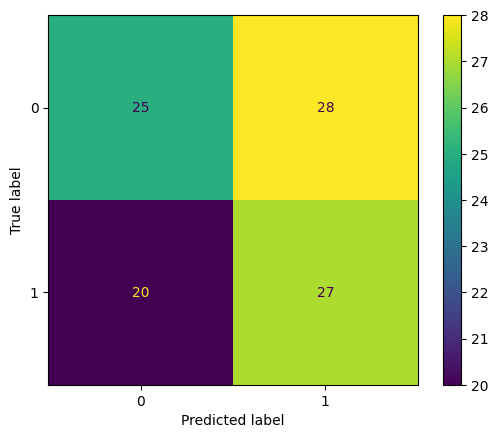

Mean Squared Error: 0.3752785190694544
Mean Absolute Error: 0.4808353113126941
Mean Absolute Percentage Error: 120798500132749296.00%
Log Loss: 1.5207351625062713


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, log_loss
import matplotlib.pyplot as plt

# Assume 'feature_matrix_with_labels' is defined as in your scenario:
num_samples = 500
num_features = 1536  # This should be the number of features excluding the label

# Simulate the feature matrix with labels
np.random.seed(0)  # For reproducibility
feature_matrix_with_labels = np.random.rand(num_samples, num_features + 1)
labels = np.random.randint(2, size=num_samples)
feature_matrix_with_labels[:, -1] = labels  # Ensure labels are in the last column

# Split data into features and labels
X = feature_matrix_with_labels[:, :-1]
y = feature_matrix_with_labels[:, -1]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input data to have three dimensions: (batch_size, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, num_features), activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1)

# Evaluate the model and print accuracies
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {val_acc:.2f}")

# Predict on validation set
y_pred_prob = model.predict(X_val_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Calculate additional metrics
mse = mean_squared_error(y_val, y_pred_prob)
mae = mean_absolute_error(y_val, y_pred_prob)
mape = mean_absolute_percentage_error(y_val, y_pred_prob)
logloss = log_loss(y_val, y_pred_prob)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
print(f"Log Loss: {logloss}")

**DWT + BI-LSTM**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_45 (Bidirectional)     │ (None, 1, 128)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_46 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 459,969 (1.75 MB)

 Trainable params: 459,969 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.5396 - loss: 0.6877 - val_accuracy: 0.4700 - val_loss: 0.7028
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7617 - loss: 0.5669 - val_accuracy: 0.5700 - val_loss: 0.7220
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8092 - loss: 0.4284 - val_accuracy: 0.5500 - val_loss: 0.7641
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8226 - loss: 0.3966 - val_accuracy: 0.5300 - val_loss: 0.8081
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8267 - loss: 0.3696 - val_accuracy: 0.4900 - val_loss: 0.8100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8280 - loss: 0.3559 - val_accuracy: 0.5300 - val_loss: 0.8200
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8368 - loss: 0.3289 - val_accuracy: 0.5300 - val_loss: 0.8490
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8346 - loss: 0.3295 - val_accuracy: 0.5300 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
Confusion Matrix:
[[26 27]
 [19 28]]


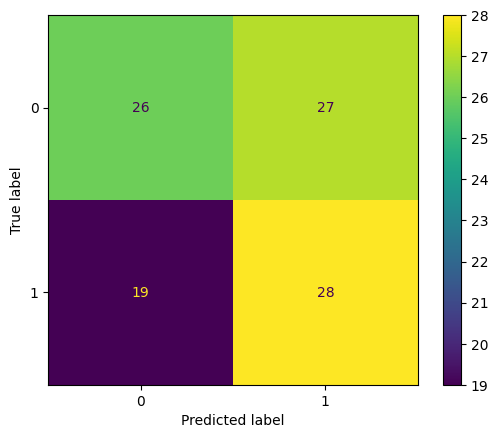

Mean Squared Error: 0.311846340568854
Mean Absolute Error: 0.48297221411485225
Mean Absolute Percentage Error: 127548518360416272.00%
Log Loss: 0.9898478844557129


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, log_loss
import matplotlib.pyplot as plt

# Assume 'feature_matrix_with_labels' is defined as in your scenario:
num_samples = 500
num_features = 1536  # This should be the number of features excluding the label
num_timesteps = 1    # Assuming each sample is treated as a single timestep

# Simulate the feature matrix with labels
np.random.seed(0)  # For reproducibility
feature_matrix_with_labels = np.random.rand(num_samples, num_features + 1)
labels = np.random.randint(2, size=num_samples)
feature_matrix_with_labels[:, -1] = labels  # Ensure labels are in the last column

# Split data into features and labels
X = feature_matrix_with_labels[:, :-1]
y = feature_matrix_with_labels[:, -1]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Data Augmentation
def augment_data(X, y):
    # Add noise
    X_noisy = X + np.random.normal(loc=0, scale=0.05, size=X.shape)

    # Time shift
    shift = np.random.randint(-5, 5)
    X_shifted = np.roll(X, shift, axis=0)

    # Concatenate original and augmented data
    X_augmented = np.vstack((X, X_noisy, X_shifted))
    y_augmented = np.concatenate((y, y, y))

    return X_augmented, y_augmented

# Augment training data
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

# Reshape input to be 3D [samples, timesteps, features] for LSTM, necessary for Conv1D
X_train_augmented = X_train_augmented.reshape((X_train_augmented.shape[0], num_timesteps, X_train_augmented.shape[1]))
X_val = X_val.reshape((X_val.shape[0], num_timesteps, X_val.shape[1]))

# Model parameters
n_units = 64
dropout_rate = 0.5

# Build the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(num_timesteps, num_features)),
    Bidirectional(LSTM(n_units, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(n_units)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train_augmented, y_train_augmented, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model and print accuracies
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {val_acc:.2f}")

# Predict on validation set
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Calculate additional metrics
mse = mean_squared_error(y_val, y_pred_prob)
mae = mean_absolute_error(y_val, y_pred_prob)
mape = mean_absolute_percentage_error(y_val, y_pred_prob)
logloss = log_loss(y_val, y_pred_prob)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
print(f"Log Loss: {logloss}")

**DWT + Classic LSTM**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                       │ (None, 1, 50)               │         317,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 50)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,451 (1.21 MB)

 Trainable params: 317,451 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.4986 - loss: 0.7138 - val_accuracy: 0.4700 - val_loss: 0.7111
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5509 - loss: 0.6881 - val_accuracy: 0.4700 - val_loss: 0.7083
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5722 - loss: 0.6826 - val_accuracy: 0.4700 - val_loss: 0.7021
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5750 - loss: 0.6822 - val_accuracy: 0.4700 - val_loss: 0.7023
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5712 - loss: 0.6810 - val_accuracy: 0.4700 - val_loss: 0.7047
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5735 - loss: 0.6744 - val_accuracy: 0.4700 - val_loss: 0.7389
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5508 - loss: 0.6822 - val_accuracy: 0.4800 - val_loss: 0.7049
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6023 - loss: 0.6595 - val_accuracy: 0.4700 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Confusion Matrix:
[[29 24]
 [22 25]]


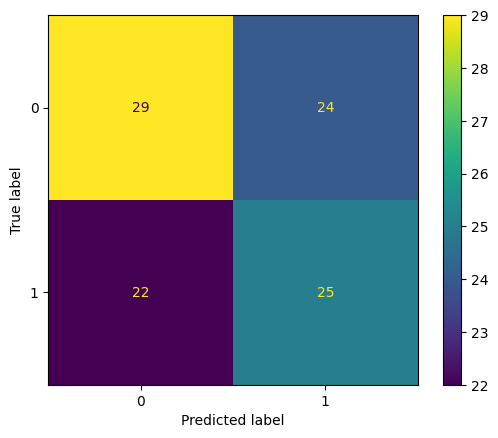

Mean Squared Error: 0.316058290780576
Mean Absolute Error: 0.4813316012173891
Mean Absolute Percentage Error: 119111192672206880.00%
Log Loss: 0.9137750768532481


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, log_loss, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to perform time shifting augmentation
def time_shift_augmentation(X, shift_range=10):
    augmented_X = []
    for sequence in X:
        shift = np.random.randint(-shift_range, shift_range)
        augmented_sequence = np.roll(sequence, shift, axis=0)
        if shift > 0:
            augmented_sequence[:shift] = 0
        else:
            augmented_sequence[shift:] = 0
        augmented_X.append(augmented_sequence)
    return np.array(augmented_X)

# Simulate the feature matrix with labels
num_samples = 500
num_features = 1536  # This should be the number of features excluding the label

np.random.seed(0)  # For reproducibility
feature_matrix_with_labels = np.random.rand(num_samples, num_features + 1)
labels = np.random.randint(2, size=num_samples)
feature_matrix_with_labels[:, -1] = labels  # Ensure labels are in the last column

# Split data into features and labels
X = feature_matrix_with_labels[:, :-1]
y = feature_matrix_with_labels[:, -1]

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform data augmentation on training data
X_train_augmented = time_shift_augmentation(X_train)

# Concatenate original and augmented data
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

# Define model
model = Sequential([
    LSTM(50, input_shape=(1, num_features), return_sequences=True),  # LSTM layer
    GlobalMaxPooling1D(),  # Global max pooling layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the accuracies
print(f"Training Accuracy: {train_acc[1]*100:.2f}")
print(f"Testing Accuracy: {test_acc[1]*100:.2f}")

# Predict on validation set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Calculate additional metrics
mse = mean_squared_error(y_test, y_pred_prob)
mae = mean_absolute_error(y_test, y_pred_prob)
mape = mean_absolute_percentage_error(y_test, y_pred_prob)
logloss = log_loss(y_test, y_pred_prob)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
print(f"Log Loss: {logloss}")

**Seizure Detection**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Example data
labels = np.array(['A', 'B', 'C', 'D', 'E'])
feature_matrix = np.random.rand(len(labels), 40)  # Placeholder for feature matrix

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Print the mapping of encoded labels to original labels
print("Label Encoder Classes:", label_encoder.classes_)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, encoded_labels, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Label Encoder Classes: ['A' 'B' 'C' 'D' 'E']
Training data shape: (4, 40) (4,)
Testing data shape: (1, 40) (1,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=5)  # Assuming 5 classes (A, B, C, D, E)
y_test_one_hot = to_categorical(y_test, num_classes=5)

print("One-Hot Encoded Training Labels Shape:", y_train_one_hot.shape)
print("One-Hot Encoded Testing Labels Shape:", y_test_one_hot.shape)

One-Hot Encoded Training Labels Shape: (4, 5)
One-Hot Encoded Testing Labels Shape: (1, 5)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load EEG data from CSV (adjust the file path as needed)
eeg_data = pd.read_csv('/content/drive/MyDrive/eeg_data.csv')

# Assuming 'feature_matrix' contains your extracted features and 'labels' are the corresponding labels
feature_matrix = eeg_data.drop('label', axis=1)  # Assuming 'label' is the column containing labels
labels = eeg_data['label']

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, encoded_labels, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier using the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate and print a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.46      0.79      0.58        14
           2       0.14      0.20      0.17        10
           3       0.69      0.38      0.49        24
           4       0.95      0.88      0.91        24

    accuracy                           0.65       100
   macro avg       0.61      0.60      0.59       100
weighted avg       0.70      0.65      0.66       100



In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

# Assuming `df` is your original DataFrame containing the dataset
df = pd.read_csv("/content/drive/MyDrive/eeg_data.csv")

# Count the number of samples per class
class_counts = df['label'].value_counts()

# Display original class counts
print("Original label counts:")
print(class_counts)

# Determine the target number of samples per class (assuming balancing with class E)
target_count = class_counts['E']

# Undersample classes A, B, C, D to match the number of samples in class E
balanced_data = []

# Loop through each class label and undersample if necessary
for label in class_counts.index:
    if label == 'E':
        # For class E, append all samples directly
        balanced_data.append(df[df['label'] == label])
    else:
        # For classes A, B, C, D, undersample to match the target_count
        samples_to_keep = df[df['label'] == label].sample(target_count, random_state=42)
        balanced_data.append(samples_to_keep)

# Concatenate the balanced data for each class
balanced_df = pd.concat(balanced_data)

# Shuffle the DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display balanced label counts
balanced_class_counts = balanced_df['label'].value_counts()
print("\nBalanced label counts:")
print(balanced_class_counts)

Original label counts:
label
A    100
B    100
C    100
D    100
E    100
Name: count, dtype: int64

Balanced label counts:
label
D    100
A    100
B    100
E    100
C    100
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# Example: Assuming 'balanced_df' is your DataFrame containing balanced data
# Extract features (X) and labels (y) from the DataFrame
features = balanced_df.drop('label', axis=1)  # Assuming 'label' is the column representing the target variable
labels = balanced_df['label']  # Extracting the target variable (labels)

# Convert features and labels to numpy arrays
X = features.values  # Features as numpy array
y = labels.values  # Labels as numpy array

# Optionally, you may need to encode categorical variables in the features
# Example: Using one-hot encoding for categorical features (if needed)
# X = pd.get_dummies(features).values

# Ensure labels are in binary format (1 for seizure present, 0 for no seizure)
# Assuming your labels are categorical ('A', 'B', 'C', 'D', 'E'), map them to binary labels
label_map = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 1}  # Define mapping based on your target class
y_binary = np.array([label_map[label] for label in y])

# Now, 'X' contains your features and 'y_binary' contains your binary labels (0 or 1)
# X should be in a numerical format suitable for model training (numpy array)
# y_binary should represent the target variable indicating seizure presence (0 or 1)

# Display shapes of X and y_binary to ensure correctness
print("Shape of features (X):", X.shape)
print("Shape of binary labels (y_binary):", y_binary.shape)

Shape of features (X): (500, 3)
Shape of binary labels (y_binary): (500,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        78
           1       1.00      0.82      0.90        22

    accuracy                           0.96       100
   macro avg       0.98      0.91      0.94       100
weighted avg       0.96      0.96      0.96       100

Confusion Matrix:
[[78  0]
 [ 4 18]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming you have loaded and prepared your features (X) and binary labels (y_binary)
# X should be a DataFrame of features (shape: [n_samples, n_features])
# y_binary should be a Series of binary labels (0 or 1) corresponding to whether seizure is present or not

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Example: Predict whether a new individual is having a seizure
# Assuming 'new_data' is a DataFrame containing features of the new individual
# Make sure 'new_data' is preprocessed in the same way as the training data (e.g., scaling, encoding)
new_data = pd.DataFrame([[27927,185,-190]])  # Insert features of the new individual here

# Use the trained model to predict whether the new individual is having a seizure
prediction = model.predict(new_data)

if prediction[0] == 1:
    print("The person is predicted to be having a seizure.")
else:
    print("The person is predicted not to be having a seizure.")

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        78
           1       1.00      0.82      0.90        22

    accuracy                           0.96       100
   macro avg       0.98      0.91      0.94       100
weighted avg       0.96      0.96      0.96       100

Confusion Matrix:
[[78  0]
 [ 4 18]]
The person is predicted not to be having a seizure.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming you have loaded and prepared your features (X) and binary labels (y_binary)
# X should be a DataFrame of features (shape: [n_samples, n_features])
# y_binary should be a Series of binary labels (0 or 1) corresponding to whether seizure is present or not

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Example: Predict whether a new individual is having a seizure
# Assuming 'new_data' is a DataFrame containing features of the new individual
# Make sure 'new_data' is preprocessed in the same way as the training data (e.g., scaling, encoding)
new_data = pd.DataFrame([[-137133,1219,-800]])  # Insert features of the new individual here

# Use the trained model to predict whether the new individual is having a seizure
prediction = model.predict(new_data)

if prediction[0] == 1:
    print("The person is predicted to be having a seizure.")
else:
    print("The person is predicted not to be having a seizure.")

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        78
           1       1.00      0.82      0.90        22

    accuracy                           0.96       100
   macro avg       0.98      0.91      0.94       100
weighted avg       0.96      0.96      0.96       100

Confusion Matrix:
[[78  0]
 [ 4 18]]
The person is predicted to be having a seizure.
